# Analysis of Attention U-Net with Custom Preprocessing (Experiment 03)

### Summary
This notebook analyzes the performance of the Attention U-Net model trained for 20 epochs with the RAovSeg custom preprocessing function. We compare its results to the previous experiments to understand the impact of this preprocessing step.

### Quantitative Findings
- **Performance**: The model achieved its best validation Dice score of **0.3104 at epoch 20**. This is lower than the baseline's peak score (0.4264).
- **Training Dynamics**: Crucially, the validation loss was still generally decreasing and the validation Dice score was still on an upward trend at the end of training. This indicates that the model **did not overfit** within 20 epochs and was likely **stopped too early**.

### Qualitative Findings (Visual Analysis)
The sample predictions reveal a significant qualitative improvement over the previous models:
- **Reduced False Positives**: The model produces much cleaner predictions with far fewer scattered, incorrect blobs. In `Sample 1`, it correctly predicts nothing, whereas previous models produced multiple false positives.
- **Improved Localization Focus**: The model is no longer "guessing" at every bright spot. It is learning to identify a smaller, more specific set of candidate regions.

### Conclusion & Next Steps
The custom preprocessing is successful at regularizing the model and preventing the rapid overfitting we saw previously. While the Dice score is lower after 20 epochs, the qualitative results are much better, and the training curves indicate that the model simply needs more time to learn.

The clear next step is to **train this same model for more epochs** to allow it to converge and find its true peak performance.

Successfully loaded model from ../models/11_attention_unet_preprocessed_best.pth
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Loaded 64 validation slices.

Visualizing 5 sample predictions...


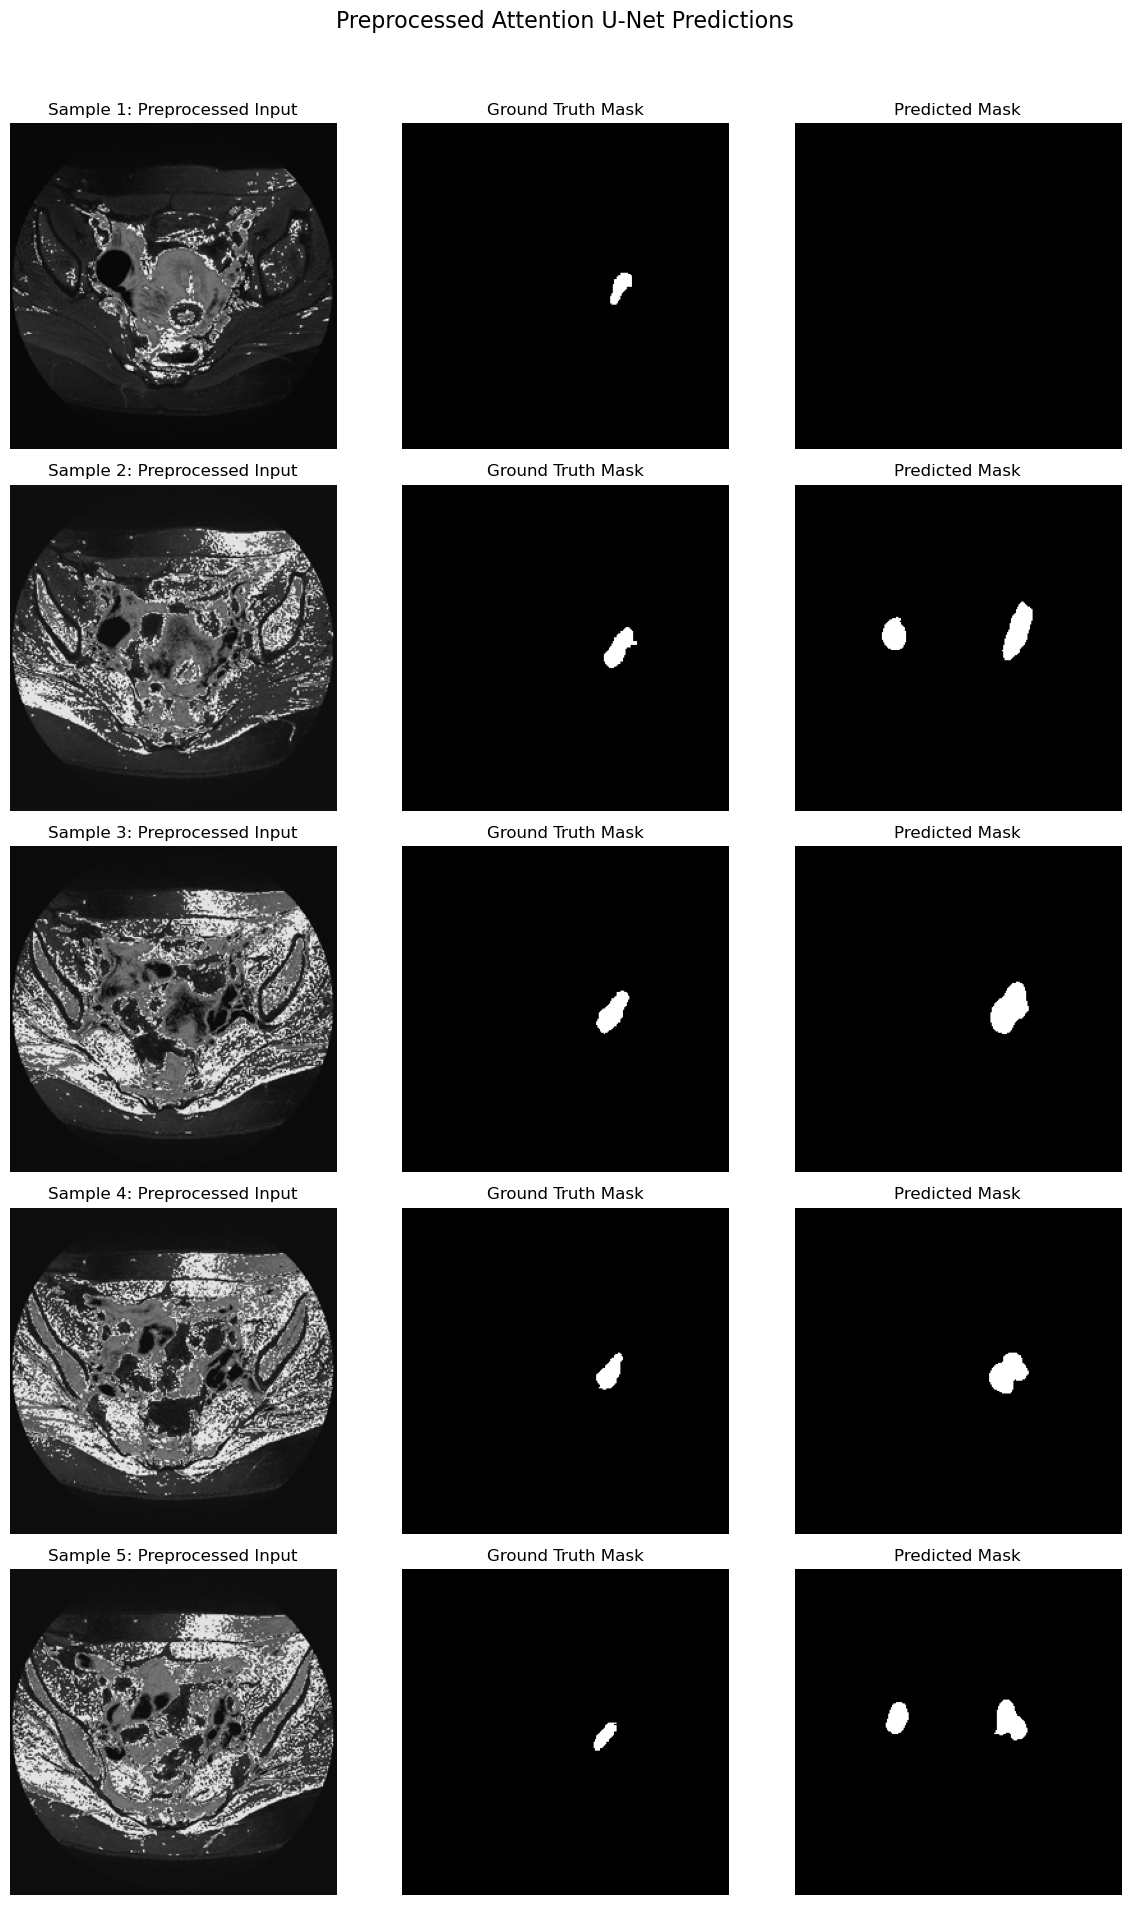

In [1]:
# --- Imports and Setup ---
import os
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np
from torch.utils.data import DataLoader, Subset

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# <--- Use the NEW dataset class that has the preprocessing logic ---
from src.data_loader import UterusDatasetWithPreprocessing 
from src.models import AttentionUNet

# --- Configuration ---
# <--- Path to the new best model from notebook 11 ---
model_path = "../models/11_attention_unet_preprocessed_best.pth" 
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
num_samples_to_show = 5

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(n_channels=1, n_classes=1).to(device)

try:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Successfully loaded model from {model_path}")
except FileNotFoundError:
    print(f"FATAL ERROR: Model file not found at {model_path}. Please run the training in notebook 11.")
    exit()

# --- Load Validation Data with Preprocessing ---
# We MUST use the same preprocessing on the validation data for analysis
val_full_dataset = UterusDatasetWithPreprocessing(manifest_path=manifest_path, image_size=image_size, augment=False)

patient_ids = val_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
val_ids = patient_ids[split_idx:]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]
val_dataset = Subset(val_full_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Loaded {len(val_dataset)} validation slices.")

# --- Perform and Visualize Inference ---
print(f"\nVisualizing {num_samples_to_show} sample predictions...")

# Note: The "Input Image" shown here will be AFTER preprocessing, which is what the model actually sees.
fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
fig.suptitle("Preprocessed Attention U-Net Predictions", fontsize=16)

with torch.no_grad():
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples_to_show:
            break
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        pred_mask = torch.sigmoid(output) > 0.5
        
        image_np = image.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_mask_np = pred_mask.cpu().squeeze().numpy()
        
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title(f"Sample {i+1}: Preprocessed Input")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()